<a href="https://colab.research.google.com/github/fitzroypet/Background-remove-U-2-Net-Demo/blob/main/U_2_Netp_Demonstration_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-2-NETp DEMONSTRATION

**Using U-2-NETp for :**
 - **Background Removal**
 - **Bounding Box Creation**
 - **Salient Feature Highlighting**


 U-2-NET Paper: [U2-Net: Going Deeper with Nested U-Structure for Salient Object Detection](https://arxiv.org/abs/2005.09007)

 Original Repo: [U-2-Net Github repo](https://github.com/vaibhavmit074/U-2-Net-Demo)

References: X. Qin, Z. Zhang, C. Huang, M. Dehghan, O. R. Zaiane, and M. Jagersand, “U2-net: Going deeper with nested u-structure for salient object
detection,” Pattern Recognition, vol. 106, p. 107404, 2020

# SETUP

- Clone github repo: [https://github.com/vaibhavmit074/U-2-Net-Demo](https://github.com/vaibhavmit074/U-2-Net-Demo)
- Make directories for images
- Import necessary packages

Note: Uses U-2-Netp with 4.7MB weights, not U-2-Net with 176.3MB

# Make sure runtype is GPU
**Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU**

In [1]:
#@title Run this cell for setups{display-mode: "form"}
%cd /content
!/usr/local/cuda/bin/nvcc --version
!git clone https://github.com/shreyas-bk/U-2-Net
%cd /content/U-2-Net
print('making images directory')
!mkdir images
print('making results directory')
!mkdir results
print('importing...')
from google.colab import files
import os
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
from PIL import Image as Img
import cv2
from google.colab.patches import cv2_imshow
print('Done!')

/content
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
Cloning into 'U-2-Net'...
remote: Enumerating objects: 520, done.
remote: Total 520 (delta 0), reused 0 (delta 0), pack-reused 520
Receiving objects: 100% (520/520), 12.39 MiB | 15.33 MiB/s, done.
Resolving deltas: 100% (236/236), done.
/content/U-2-Net
making images directory
making results directory
importing...
Done!


# UPLOAD IMAGES

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#@title Run this cell to upload images{display-mode: "form"}
%cd /content/U-2-Net/images
uploaded = files.upload()
%cd /content/U-2-Net

/content/U-2-Net/images


Saving image (141).JPG to image (141).JPG
Saving image (142).JPG to image (142).JPG
Saving image (143).JPG to image (143).JPG
Saving image (144).JPG to image (144).JPG
/content/U-2-Net


# RESULTS
 - Run u2net_test.py
 - Remove Background
 - Create Bounding Box
 - Highlight Salient Features

In [5]:
import os
os.chdir("/content/drive/My Drive")
!ls

'Amadi Ama Analysis'   plantvillage
'Colab Notebooks'      plantvillagedataset.zip
 dataset	      'Policy documents'
 dataset_new	       Predictions
 General	      'Progress report.txt'
'Holiday in Wales'    'Tensorflow model'
 images		      'Think Pacific'
 model.tflite	      'Volunteer registration form.gsheet'


In [8]:
import os
os.chdir("/content/U-2-Net")
!ls

data_loader.py	model	   results     u2net_test.py
images		README.md  u2netp.pth  u2net_train.py


['/content/U-2-Net/images/image (142).JPG', '/content/U-2-Net/images/image (144).JPG', '/content/U-2-Net/images/image (143).JPG', '/content/U-2-Net/images/image (141).JPG']
inferencing: image (142).JPG
inferencing: image (144).JPG
inferencing: image (143).JPG
inferencing: image (141).JPG

INPUT         BACKGROUND REMOVED          BOUNDING BOX          ALIENT MAP



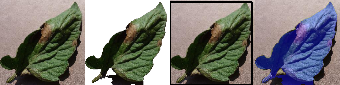

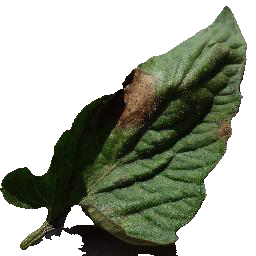


INPUT         BACKGROUND REMOVED          BOUNDING BOX          ALIENT MAP



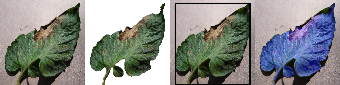

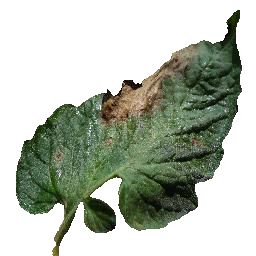


INPUT         BACKGROUND REMOVED          BOUNDING BOX          ALIENT MAP



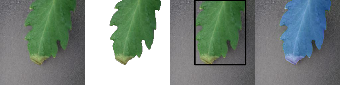

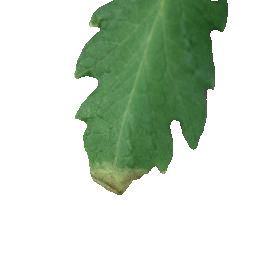


INPUT         BACKGROUND REMOVED          BOUNDING BOX          ALIENT MAP



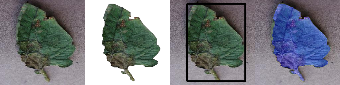

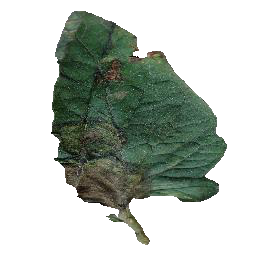

In [11]:
#@title Run this cell for results{display-mode: "form"}

# This code will be hidden when the notebook is loaded.

!python -W ignore u2net_test.py

image_dir = os.path.join(os.getcwd(), 'images')
names = [name[:-4] for name in os.listdir(image_dir)]
THRESHOLD = 0.9
RESCALE = 255
LAYER = 2
COLOR = (0, 0, 0)
THICKNESS = 4
SAL_SHIFT = 100



for name in names:

  # BACKGROUND REMOVAL

  output = load_img('/content/U-2-Net/results/'+name+'.png')
  out_img = img_to_array(output)
  out_img /= RESCALE

  out_img[out_img > THRESHOLD] = 1
  out_img[out_img <= THRESHOLD] = 0

  shape = out_img.shape
  a_layer_init = np.ones(shape = (shape[0],shape[1],1))
  mul_layer = np.expand_dims(out_img[:,:,0],axis=2)
  a_layer = mul_layer*a_layer_init
  rgba_out = np.append(out_img,a_layer,axis=2)

  input = load_img('/content/U-2-Net/images/'+name+'.JPG')
  inp_img = img_to_array(input)
  inp_img /= RESCALE

  a_layer = np.ones(shape = (shape[0],shape[1],1))
  rgba_inp = np.append(inp_img,a_layer,axis=2)

  rem_back = (rgba_inp*rgba_out)
  rem_back_scaled = rem_back*RESCALE


  # BOUNDING BOX CREATION

  out_layer = out_img[:,:,LAYER]
  x_starts = [np.where(out_layer[i]==1)[0][0] if len(np.where(out_layer[i]==1)[0])!=0 else out_layer.shape[0]+1 for i in range(out_layer.shape[0])]
  x_ends = [np.where(out_layer[i]==1)[0][-1] if len(np.where(out_layer[i]==1)[0])!=0 else 0 for i in range(out_layer.shape[0])]
  y_starts = [np.where(out_layer.T[i]==1)[0][0] if len(np.where(out_layer.T[i]==1)[0])!=0 else out_layer.T.shape[0]+1 for i in range(out_layer.T.shape[0])]
  y_ends = [np.where(out_layer.T[i]==1)[0][-1] if len(np.where(out_layer.T[i]==1)[0])!=0 else 0 for i in range(out_layer.T.shape[0])]
  
  startx = min(x_starts)
  endx = max(x_ends)
  starty = min(y_starts)
  endy = max(y_ends)
  start = (startx,starty)
  end = (endx,endy)

  box_img = inp_img.copy()
  box_img = cv2.rectangle(box_img, start, end, COLOR, THICKNESS)
  box_img = np.append(box_img,a_layer,axis=2)
  box_img_scaled = box_img*RESCALE


  # SALIENT FEATURE MAP

  sal_img = inp_img.copy()
  add_layer = out_img.copy()
  add_layer[add_layer==1] = SAL_SHIFT/RESCALE
  sal_img[:,:,LAYER] += add_layer[:,:,LAYER]
  sal_img = np.append(sal_img,a_layer,axis=2)
  sal_img_scaled = sal_img*RESCALE
  sal_img_scaled[sal_img_scaled>RESCALE] = RESCALE


  # OUTPUT RESULTS

  inp_img*=RESCALE
  inp_img = np.append(inp_img,RESCALE*a_layer,axis=2)
  inp_img = cv2.resize(inp_img,(int(shape[1]/3),int(shape[0]/3)))
  rem_back = cv2.resize(rem_back_scaled,(int(shape[1]/3),int(shape[0]/3)))
  box_img = cv2.resize(box_img_scaled,(int(shape[1]/3),int(shape[0]/3)))
  sal_img = cv2.resize(sal_img_scaled,(int(shape[1]/3),int(shape[0]/3)))
  result = np.concatenate((inp_img,rem_back,box_img,sal_img),axis=1)
  result_img = Img.fromarray(result.astype('uint8'), 'RGBA')
  print('\nINPUT         BACKGROUND REMOVED          BOUNDING BOX          ALIENT MAP\n')
  display(result_img)

  rem_bg = Img.fromarray(rem_back_scaled.astype('uint8'), 'RGBA')
  display(rem_bg)


  with open('/content/drive/MyDrive/dataset_new/Tomato___Bacterial_spot/'+name+'.png', 'w') as f: 
  
    f.write('rem_bg')